In [1]:
from zipfile import ZipFile
import pathlib
from datetime import datetime
from dateutil import parser

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

The `sentiment140` dataset contains 1,600,000 tweets extracted using the twitter api.

The tweets have been annotated *(0 = negative, 4 = positive)* and they can be used to detect sentiment.

It contains the following 6 fields:
- `target`: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
- `ids`: The id of the tweet ( 2087)
- `date`: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- `flag`: The query (lyx). If there is no query, then this value is NO_QUERY.
- `user`: the user that tweeted (robotickilldozr)
- `text`: the text of the tweet (Lyx is cool)

In [2]:
source = pathlib.Path(pathlib.Path().absolute(), 'data', 'sentiment140.zip')

In [3]:
# Method 2
df = pd.read_csv(
    source, 
    compression='zip', 
    encoding='cp1252', 
    header=None, 
    names=['target', 'ids', 'date', 'flag', 'user', 'text'],
    #parse_dates=['date'],
    #infer_datetime_format=True,
    #date_parser=parse_tweet_dates,
)

In [4]:
display(df.head(2), df.shape)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


(1600000, 6)

#### Regardons les types des colonnes et ajustons si nécessaire

In [5]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
df = df.astype({
    "target": 'category', 
    "ids": 'category',
    #"date": 'datetime64',
    "flag": 'category',
    "user": 'category',
    #"text": 'object',
})

In [7]:
df.dtypes

target    category
ids       category
date        object
flag      category
user      category
text        object
dtype: object

In [8]:
df.head(2)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


### Commençons par chercher les éventuels doublons

#### Vérifions sur l'ensemble des colonnes

In [9]:
df.duplicated().sum()

0

#### A présent, vérifions sans tenir compte de la `target` au cas ou certains doublons auraient les deux valeurs

In [10]:
subset = ['ids', 'date', 'flag', 'user', 'text']
df.duplicated(subset=subset).sum()

1685

In [11]:
df[df.duplicated(keep=False, subset=subset)].sort_values('text').head(10)

,target,ids,date,flag,user,text
1394129,4,2053581479,Sat Jun 06 05:02:55 PDT 2009,NO_QUERY,FunStarLiz,British weather is back i see! Oh well Birtne...
385331,0,2053581479,Sat Jun 06 05:02:55 PDT 2009,NO_QUERY,FunStarLiz,British weather is back i see! Oh well Birtne...
1077756,4,1967735038,Fri May 29 20:07:06 PDT 2009,NO_QUERY,macpoulet67,Raining tomorrow afternoon but its going to b...
184535,0,1967735038,Fri May 29 20:07:06 PDT 2009,NO_QUERY,macpoulet67,Raining tomorrow afternoon but its going to b...
118605,0,1827871029,Sun May 17 11:37:14 PDT 2009,NO_QUERY,mckyliecooper,Uhm.. science! -.- Verrrry boring and LONG G...
968532,4,1827871029,Sun May 17 11:37:14 PDT 2009,NO_QUERY,mckyliecooper,Uhm.. science! -.- Verrrry boring and LONG G...
1443107,4,2062079422,Sat Jun 06 22:17:07 PDT 2009,NO_QUERY,kiarapop,back to maths. i wish i could stab it. but at...
419860,0,2062079422,Sat Jun 06 22:17:07 PDT 2009,NO_QUERY,kiarapop,back to maths. i wish i could stab it. but at...
190549,0,1969383342,Fri May 29 23:51:54 PDT 2009,NO_QUERY,iSelah,but then again
1086997,4,1969383342,Fri May 29 23:51:54 PDT 2009,NO_QUERY,iSelah,but then again


>#### On constate que l'on a 1685 échantillons pour lesquels on a à la fois une target *positive* (4) et une target *negative* (0)...
> comme on ne connait pas la véritable target des ces échantillons en double, il nous faut supprimer les 3370 *(2 x 1685)*

In [12]:
df.drop_duplicates(keep=False, subset=subset, inplace=True)

In [13]:
display(df.head(2), df.shape)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


(1596630, 6)

In [14]:
df.ids.duplicated().sum()

0

In [15]:
df.ids.describe()

count        1596630
unique       1596630
top       1467810369
freq               1
Name: ids, dtype: int64

#### Enfin, vérifions si l'on a des `textes` qui apparaissent plusieurs fois avec la même `target`

In [16]:
subset= ['text']
df.duplicated(subset=subset).sum()

16836

In [17]:
df[df.duplicated(keep=False, subset=subset)].sort_values('text').head(10)

,target,ids,date,flag,user,text
271505,0,1990029536,Mon Jun 01 03:38:42 PDT 2009,NO_QUERY,Jana1503,David must be hospitalized for five days end...
271472,0,1990023076,Mon Jun 01 03:37:19 PDT 2009,NO_QUERY,Jana1503,David must be hospitalized for five days end...
1132074,4,1975956536,Sat May 30 16:16:11 PDT 2009,NO_QUERY,dstocum,bathroom is clean..... now on to more enjoya...
1132076,4,1975956610,Sat May 30 16:16:11 PDT 2009,NO_QUERY,DavidStocum,bathroom is clean..... now on to more enjoya...
540173,0,2199659424,Tue Jun 16 17:49:15 PDT 2009,NO_QUERY,cutthroatpixie,#IMISSCATH #IMISSCATH #IMISSCATH #IMISSCATH #...
540159,0,2199656747,Tue Jun 16 17:49:00 PDT 2009,NO_QUERY,cutthroatpixie,#IMISSCATH #IMISSCATH #IMISSCATH #IMISSCATH #...
1364947,4,2049859280,Fri Jun 05 17:37:43 PDT 2009,NO_QUERY,MonicaEira,#seb-day #seb-day #seb-day #seb-day #seb-day ...
1357123,4,2047924312,Fri Jun 05 14:23:16 PDT 2009,NO_QUERY,DihDesrosiers,#seb-day #seb-day #seb-day #seb-day #seb-day ...
331063,0,2012536119,Tue Jun 02 20:49:46 PDT 2009,NO_QUERY,iShatara,*tear*
287201,0,1994140773,Mon Jun 01 11:28:38 PDT 2009,NO_QUERY,vanitiiluv,*tear*


>#### On constate que l'on a encore 16836 échantillons dont les textes apparaissent plusieurs fois dans le jeu de données
> il convient donc de n'en garder qu'un seul exemplaire de chaque

In [18]:
df.drop_duplicates(keep='first', subset=subset, inplace=True)

In [19]:
display(df.head(2), df.shape)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


(1579794, 6)

In [20]:
df.text.describe()

count                                               1579794
unique                                              1579794
top       @switchfoot http://twitpic.com/2y1zl - Awww, t...
freq                                                      1
Name: text, dtype: object

### Analysons la colonne `target`
#### Regardons sa distribution

In [21]:
df.target.value_counts()

4    791281
0    788513
Name: target, dtype: int64

>#### On constate donc que les targets sont équitablement distribuées entre 0 *(negative)* et 4 *(positive)*, mais qu'il n'y a pas de 2 *(neutral)*
> il n'est donc pas nécessaire d'effectuer un ré-équilibrage, mais nous pourrions changer la colonne en bool ou rendre les labels plus clairs.

In [22]:
remap = {0: "negative", 4: "positive"}
df.replace({"target": remap}, inplace=True)

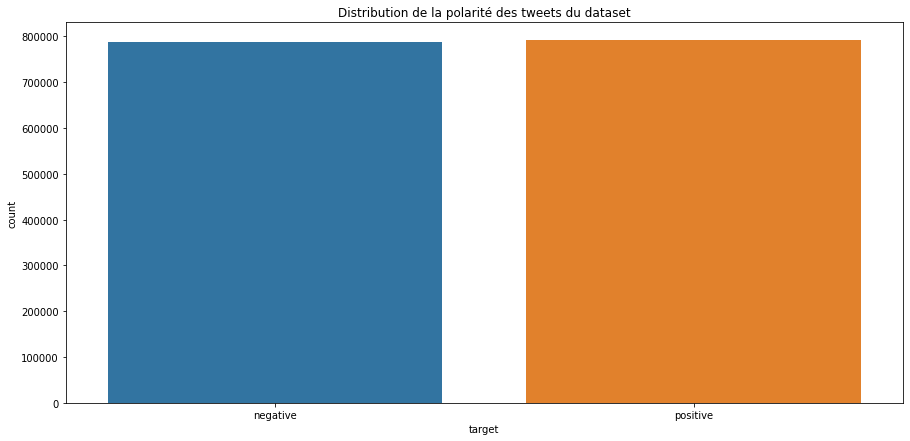

In [23]:
fig = plt.figure(figsize=(15, 7))
sns.barplot(data=df.target.value_counts().reset_index().rename(columns={'target':'count', 'index':'target'}), x='target', y='count')
plt.title("Distribution de la polarité des tweets du dataset")
plt.show()

### Analysons la colonne `ids`

In [24]:
df.ids.duplicated().sum()

0

---
>#### `TODO`  done ✅ | todo ❌ |
> - ✅ Supprimer la colonne `ids` du jeu de données de travail.<br><u>*(action: faite juste en dessous)*</u>

In [25]:
df.drop(columns=['ids'], inplace=True)

In [26]:
display(df.head(2), df.shape)

,target,date,flag,user,text
0,negative,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,negative,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


(1579794, 5)

### Analysons la colonne `date`

In [27]:
def parse_tweet_dates(date_time_str):
    return parser.parse(date_time_str,  tzinfos={"PDT": -7*3600})

In [28]:
df['date'] = df.date.apply(parse_tweet_dates)

In [29]:
display(df.head(2), df.shape)

,target,date,flag,user,text
0,negative,2009-04-06 22:19:45-07:00,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,negative,2009-04-06 22:19:49-07:00,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


(1579794, 5)

#### Regardons les limites de la periode de publication des tweets de notre dataset

In [30]:
df.date.describe(datetime_is_numeric=True)

count                                1579794
mean     2009-05-31 06:53:34.174260992-07:00
min                2009-04-06 22:19:45-07:00
25%                2009-05-28 22:53:24-07:00
50%                2009-06-02 02:56:40-07:00
75%                2009-06-15 05:14:33-07:00
max                2009-06-25 10:28:31-07:00
Name: date, dtype: object

>#### On a donc des tweets dont les dates s'étalent du 06/04/2009 au 25/06/2009
> Il n'y a pas de raison que le lexique utilisé pour qualifier ce qui est *positif* ou *négatif* change en si peu de temps, donc on peut conserver l'ensemble de l'intervalle

#### Regardons à présent la distribution des tweet dans le temps

In [31]:
def plot_bars(data_, title, labels_modulo=1, labels_rotation=90, show_values=True, x_label=None, y_label="Nombre de commandes"):

    fig = plt.figure(figsize=(15, 4))
    ax = sns.barplot(data=data_)
    if show_values:
        ax.bar_label(ax.containers[0])
    new_ticks = [i.get_text() for i in ax.get_xticklabels()]
    plt.xticks(range(0, len(new_ticks), labels_modulo), new_ticks[::labels_modulo], rotation=labels_rotation)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.show()

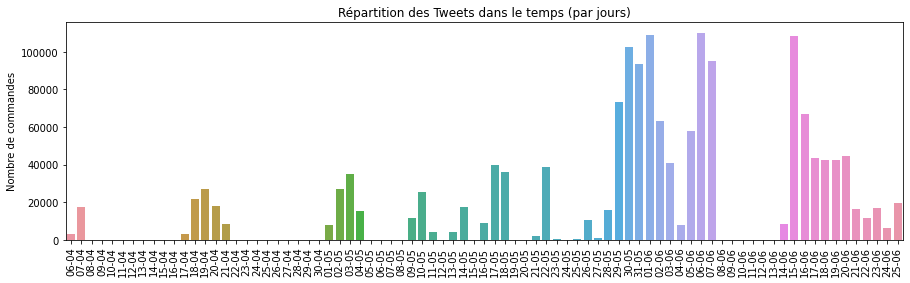

In [32]:
select = df[['date']].copy()
select['short_date'] = select.date.apply(lambda x: x.strftime("%Y-%m-%d"))
#selection['short_date'] = selection.date.apply(lambda x: datetime.strptime(x[4:10] + x[-5:], "%b %d %Y").strftime("%m %d %Y"))
select = pd.DataFrame(select.groupby('short_date').size(), columns=['count'])# .sort_values('short_date')

# add missing dates
idx = pd.date_range('2009-04-06', '2009-06-25')
select.reset_index(inplace=True)
select.index = pd.DatetimeIndex(select['short_date'])
select = select.reindex(idx, fill_value=0)
select = select.drop(columns=['short_date'])
select.index = select.index.strftime('%d-%m')
    
plot_bars(select.T, "Répartition des Tweets dans le temps (par jours)", labels_modulo=1, show_values=False)

>#### On constate que tweets sont inégalement répartis sur notre intervalle de temps
> mais c'est à priori sans conséquence *(selon notre compréhension du jeu de données à ce stade)*

---
>#### `TODO`  done ✅ | todo ❌ |
> - ✅ Supprimer la colonne `date` du jeu de données de travail.<br><u>*(action: faite juste en dessous)*</u>

In [33]:
df.drop(columns=['date'], inplace=True)

In [34]:
display(df.head(2), df.shape)

,target,flag,user,text
0,negative,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,negative,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


(1579794, 4)

### Analysons la colonne `flag`

In [35]:
df.flag.value_counts(dropna=False)

NO_QUERY    1579794
Name: flag, dtype: int64

>#### Il n'y a qu'une seule valeur dans cette colonne
> elle ne présente donc aucun intérêt et peut être retirée.

---
>#### `TODO`  done ✅ | todo ❌ |
> - ✅ Supprimer la colonne `flag` du jeu de données de travail.<br><u>*(action: faite juste en dessous)*</u>

In [36]:
df.drop(columns=['flag'], inplace=True)

In [37]:
display(df.head(2), df.shape)

,target,user,text
0,negative,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,negative,scotthamilton,is upset that he can't update his Facebook by ...


(1579794, 3)

### Analysons la colonne `user`

In [38]:
df.user.describe()

count      1579794
unique      653858
top       lost_dog
freq           549
Name: user, dtype: object

>#### On a une répartition inégale du nombre de Tweets par utilisateurs
> mais c'est à priori sans conséquence *(selon notre compréhension du jeu de données à ce stade)*

---
>#### `TODO`  done ✅ | todo ❌ |
> - ✅ Supprimer la colonne `user` du jeu de données de travail.<br><u>*(action: faite juste en dessous)*</u>

In [39]:
df.drop(columns=['user'], inplace=True)

In [40]:
display(df.head(2), df.shape)

,target,text
0,negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,negative,is upset that he can't update his Facebook by ...


(1579794, 2)

### Analysons la colonne `text`